In [17]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

In [18]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [19]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [20]:
dirpath = 'SMAI-PCAdataset/IIIT-CFW/'
# print(dirpath)
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


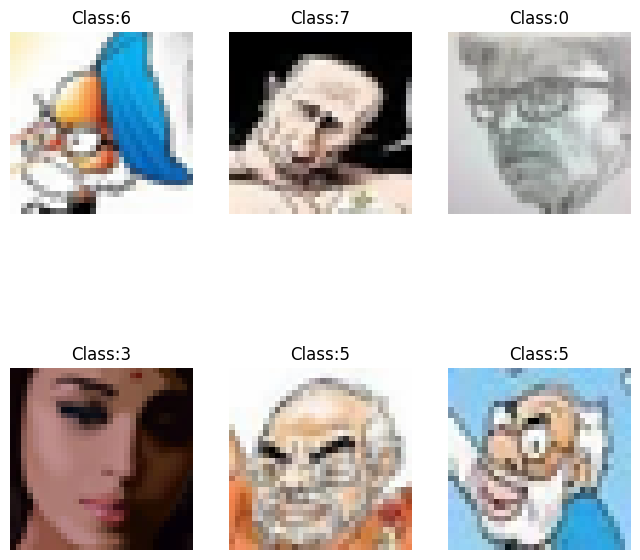

In [21]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [22]:
import plotly.express as px

# some functions of the following class has been generated by chatgpt
class PCAAnalyzer:
    def __init__(self, X):
        self.X = X
        self.mean = None
        self.std_dev = None
        self.X_scaled = None
        self.cov_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.explained_variances = None

    def standardize_features(self):
        self.mean = np.mean(self.X, axis=0)
        self.std_dev = np.std(self.X, axis=0)
        self.X_scaled = (self.X - self.mean) / self.std_dev

        if self.X_scaled.ndim > 2:
            self.X_scaled = self.X_scaled.reshape(self.X_scaled.shape[0], -1)

    def calculate_covariance_matrix(self):
        self.cov_matrix = np.cov(self.X_scaled, rowvar=False)

    def calculate_eigenvalues_and_eigenvectors(self):
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.cov_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]

    def calculate_cumulative_explained_variance(self):
        self.explained_variances = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)

    def plot_cumulative_variance(self):
        fig = px.line(x=range(1, len(self.explained_variances) + 1), y=self.explained_variances, markers=True, title='Cumulative Explained Variance vs. Number of Principal Components')
        fig.update_layout(xaxis_title='Number of Principal Components', yaxis_title='Cumulative Explained Variance')
        fig.show()



analyzer = PCAAnalyzer(X)

# Perform PCA analysis
analyzer.standardize_features()
analyzer.calculate_covariance_matrix()
analyzer.calculate_eigenvalues_and_eigenvectors()
analyzer.calculate_cumulative_explained_variance()

# Plot the cumulative explained variance
print('Graph for IIIT-CFW dataset')

analyzer.plot_cumulative_variance()

Graph for IIIT-CFW dataset


672


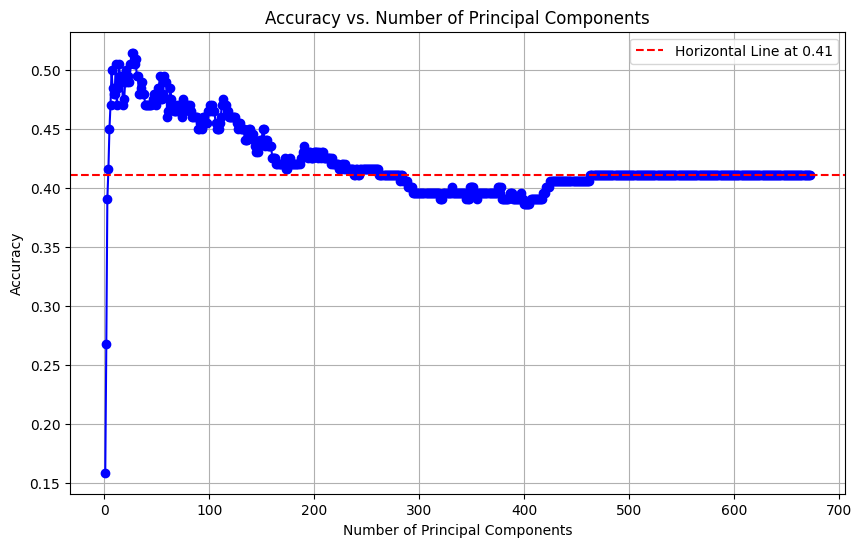

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_standardized = (X_train - mean) / std
X_test_standardized = (X_test - mean) / std

X_train_standardized = X_train_standardized.reshape(X_train_standardized.shape[0], -1)
X_test_standardized = X_test_standardized.reshape(X_test_standardized.shape[0], -1)

knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean')

knn.fit(X_train_standardized, y_train)

y_pred = knn.predict(X_test_standardized)

accuracy1 = accuracy_score(y_test, y_pred)

# print(len(X_train_standardized[0]))

n_features = X.shape[0]
print(n_features)
n_components_range = range(1, n_features + 1)
accuracies = []

analyzer = PCAAnalyzer(X_train)

analyzer.standardize_features()
analyzer.calculate_covariance_matrix()
analyzer.calculate_eigenvalues_and_eigenvectors()



for i in n_components_range:
    
    top_eigenvectors = analyzer.eigenvectors[:, :i]

    # print(len(top_eigenvectors[0]))

    X_train_pca = X_train_standardized.dot(top_eigenvectors)
    X_test_pca = X_test_standardized.dot(top_eigenvectors)

    knn = KNeighborsClassifier(n_neighbors=10,metric='euclidean')
    knn.fit(X_train_pca, y_train)

    accuracy = knn.score(X_test_pca, y_test)
    accuracies.append(accuracy)

#plotting code given by chatgpt
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Principal Components')
plt.grid()

# Add a horizontal line at y_val
y_val = 0.85  # Change this to your desired y-value
plt.axhline(y=accuracy1, color='r', linestyle='--', label=f'Horizontal Line at {accuracy1:.2f}')
plt.legend()  # Add a legend to the plot

plt.show()

# Observations:

1) PCA reduces the number of features in the dataset while retaining as much variance as possible. This can be particularly useful when we deal with high-dimensional data. Thus we observe that with fewer dimensions in the data generated after PCA, kNN calculations become comparatively quicker, as there are fewer features which have to be considered for generating the distances.

In [24]:
data1=np.load('data1.npy', allow_pickle=True)

X1=[]

for i in range(len(data1)):
    X1.append(data1[i][1])


analyzer1 = PCAAnalyzer(X1)

analyzer1.standardize_features()
analyzer1.calculate_covariance_matrix()
analyzer1.calculate_eigenvalues_and_eigenvectors()
analyzer1.calculate_cumulative_explained_variance()

print('Graph for Assignment1 Pictionary dataset')
analyzer1.plot_cumulative_variance()


Graph for Assignment1 Pictionary dataset


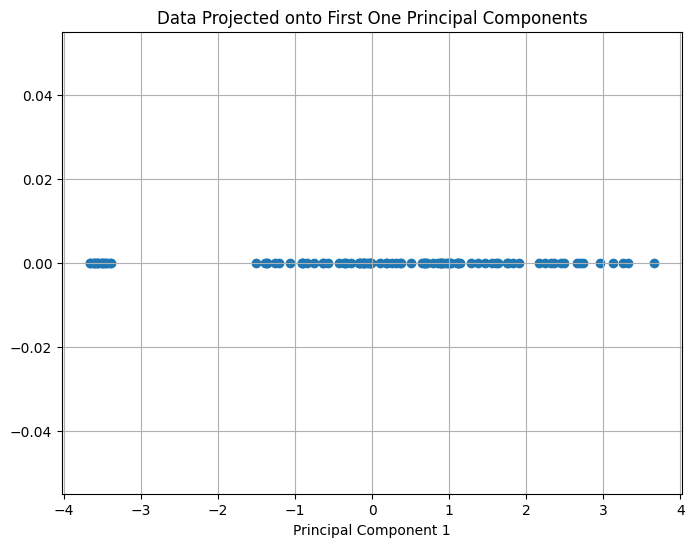

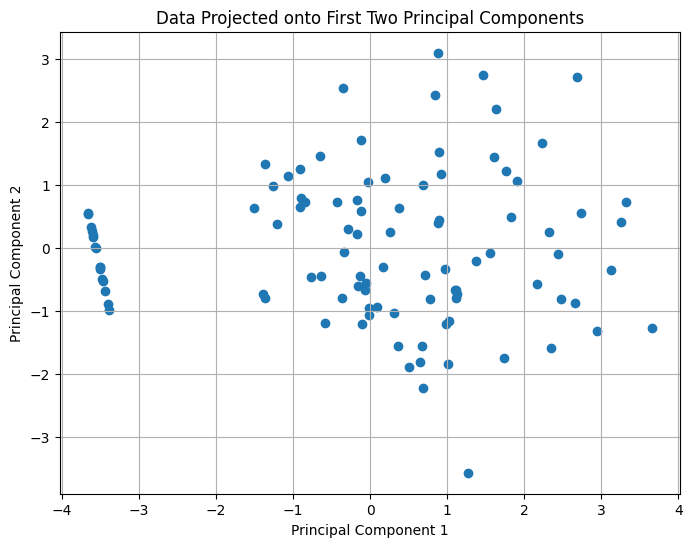

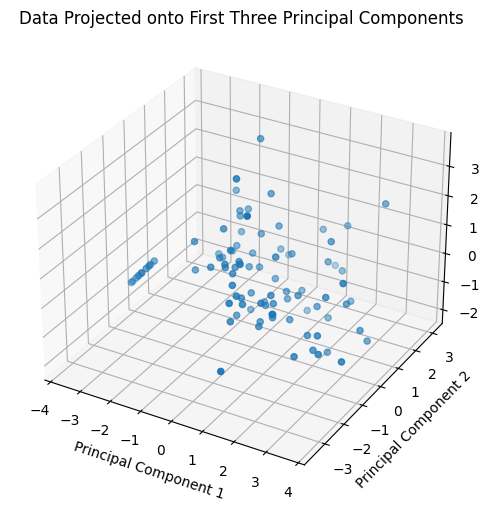

In [25]:
import pandas as pd

data=pd.read_csv('drawer_attributes.csv')

X=list(data.columns)

data=pd.DataFrame(data)

data_standardized = (data - data.mean()) / data.std()

cov_matrix = np.cov(data_standardized, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

#plotting code generated by chatgpt
num_components = 1  # Change this as needed

# Select the top num_components eigenvectors
top_eigenvectors = eigenvectors[:, :num_components]

# Project the data onto the selected eigenvectors
data_projected = np.dot(data_standardized, top_eigenvectors)

# Plot the data projected onto the first one principal components
plt.figure(figsize=(8, 6))
plt.scatter(data_projected[:, 0],np.zeros_like(data_projected[:, 0]))
plt.xlabel('Principal Component 1')
plt.ylabel('')
plt.title('Data Projected onto First One Principal Components')
plt.grid(True)

plt.show()

# Specify the number of principal components to keep
num_components = 2  # Change this as needed

# Select the top num_components eigenvectors
top_eigenvectors = eigenvectors[:, :num_components]

# Project the data onto the selected eigenvectors
data_projected = np.dot(data_standardized, top_eigenvectors)

# Plot the data projected onto the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(data_projected[:, 0], data_projected[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Projected onto First Two Principal Components')
plt.grid(True)

plt.show()

# Specify the number of principal components to keep
num_components = 3  # Change this as needed

# Select the top num_components eigenvectors
top_eigenvectors = eigenvectors[:, :num_components]

# Project the data onto the selected eigenvectors
data_projected = np.dot(data_standardized, top_eigenvectors)

# Plot the data projected onto the first three principal components
plot=plt.figure(figsize=(8, 6))
ax=plot.add_subplot(111,projection='3d')
ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data Projected onto First Three Principal Components')
# plt.grid(True)

plt.show()


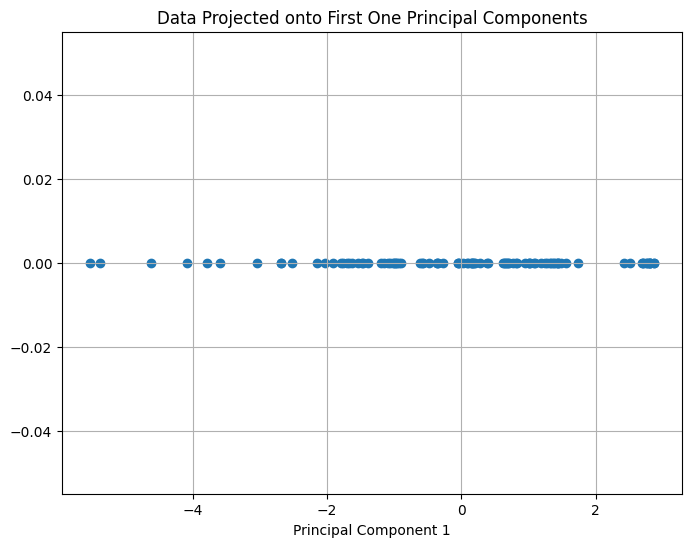

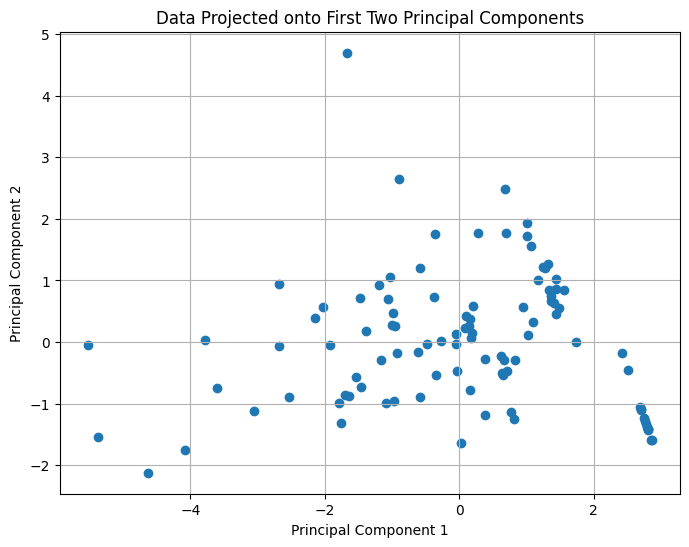

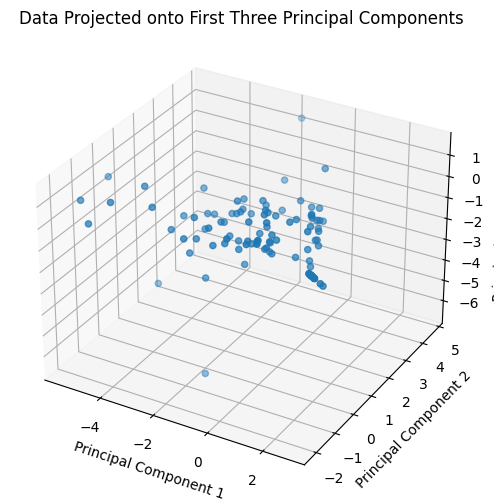

In [26]:
import pandas as pd

data=pd.read_csv('guesser_attributes.csv')

X=list(data.columns)

data=pd.DataFrame(data)

data_standardized = (data - data.mean()) / data.std()

cov_matrix = np.cov(data_standardized, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

#plotting code generated by chatgpt
num_components = 1  # Change this as needed

# Select the top num_components eigenvectors
top_eigenvectors = eigenvectors[:, :num_components]

# Project the data onto the selected eigenvectors
data_projected = np.dot(data_standardized, top_eigenvectors)

# Plot the data projected onto the first one principal components
plt.figure(figsize=(8, 6))
plt.scatter(data_projected[:, 0],np.zeros_like(data_projected[:, 0]))
plt.xlabel('Principal Component 1')
plt.ylabel('')
plt.title('Data Projected onto First One Principal Components')
plt.grid(True)

plt.show()

# Specify the number of principal components to keep
num_components = 2  # Change this as needed

# Select the top num_components eigenvectors
top_eigenvectors = eigenvectors[:, :num_components]

# Project the data onto the selected eigenvectors
data_projected = np.dot(data_standardized, top_eigenvectors)

# Plot the data projected onto the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(data_projected[:, 0], data_projected[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Projected onto First Two Principal Components')
plt.grid(True)

plt.show()

# Specify the number of principal components to keep
num_components = 3  # Change this as needed

# Select the top num_components eigenvectors
top_eigenvectors = eigenvectors[:, :num_components]

# Project the data onto the selected eigenvectors
data_projected = np.dot(data_standardized, top_eigenvectors)

# Plot the data projected onto the first three principal components
plot=plt.figure(figsize=(8, 6))
ax=plot.add_subplot(111,projection='3d')
ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data Projected onto First Three Principal Components')
# plt.grid(True)

plt.show()


# Observation

1) After PCA, PC1 i.e. the first principal component captures the most variance of data and indicates the direction in the feature space along which the data varies the most.
 
2) PC2 captures the second most variance and is orthogonal to PC1. It is independent of PC1 and indicates the second-most important pattern or structure in the data.

3) As the Principal components increase, each subsequent features are captured in decreasing amounts of variance.